In [1]:

#  O my body, make of me always a man who questions!

import spacy
import re
import pandas as pd
import numpy as np
import requests
from spacy.matcher import Matcher 

import networkx as nx

import matplotlib.pyplot as plt

from common import *

nlp = spacy.load('en_core_web_sm')

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


# Sentence preparation

In [2]:
book = read_file('data/Strang-Linear Algebra.txt')

In [3]:
def sentence_fits(s):
    """Check if sentence contains only one subject and one object"""
    deps = ''.join([token.dep_ for token in nlp(s)])
    return deps.count('obj') == 1 & deps.count('subj') == 1
    

In [4]:
chapter = list(get_one_chapter_strang(2, book, subsections=False,
                                      split=True, sentence_spliter=lambda ss: nlp(ss).sents))[0]

sentences = list(filter(sentence_fits, chapter))
sentences[:50]

['Elimination can simplify, one entry at a time, the linear system',
 'Fortunately it also simplifies the theory.',
 'Then that circle of ideas will be complete.',
 '= b. Our chief object is to achieve a different and deeper understanding.',
 'This chapter may be more difficult than the first one.',
 'They are denoted by R1;R2;R3; : : :; the space',
 'Addition obeys the commutative law',
 'If x = (1;0;0;3), then 2x (and also x+x) has components 2, 0, 0, 6.',
 'We give three examples: 1.',
 'The laws for x+y and cx stay unchanged.',
 'In this case the vectors are matrices!',
 'We can add two matrices, and A+B = B+A, and there is a zero matrix, and so on.',
 'This space is almost the same as R6.',
 'The space includes f (x) =',
 'somewhere elsethey are inside the standard spaces Rn.',
 'That plane is a vector space in its own right.',
 'Notice in particular that the zero vector will belong to every subspace.',
 'the largest subspace is the whole of the original space.',
 'Every multiple 

In [5]:
len(sentences)

325

# Sentence selection

## Relations extraction

Extracting entity pairs (object with subject) and relations (chunks that connect object and subject).

In [6]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)

    pattern = [
            {'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}
    ] 

    matcher.add("matching_pattern", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text 

In [7]:
relations = [get_relation(i) for i in sentences]
pd.Series(relations).value_counts()[:25]

is                 77
are                24
has                19
contains            9
have                9
be                  8
Suppose             4
are independent     4
Notice              3
gives               3
go to               3
was                 3
equals              3
span                3
is in               3
denoted by          3
be complete         2
given               2
have more           2
n.                  2
become              2
spanned by          2
fill                2
want                2
comes from          2
dtype: int64

In [8]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check if token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check if token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
                    
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.replace('  ', ' ').strip(), ent2.replace('  ', ' ').strip()]


In [9]:
objects = [''] * len(sentences)
subjects = [''] * len(sentences)

for i, s in enumerate(sentences):
    subjects[i], objects[i] = get_entities(s)
    
subjects = np.array(subjects)
objects = np.array(objects)

subjects[:25]

array(['Elimination', 'Fortunately it', 'Then circle', 'chief object',
       'chapter', 'They', 'Addition', 'then 2x', 'We', 'laws', 'vectors',
       'We', 'space', 'space', 'somewhere elsethey', 'plane',
       'zero vector', 'largest subspace', 'multiple cx',
       'smallest subspace', 'Another', 'zero matrix', 'It', 'Combination',
       'we'], dtype='<U33')

## Constructing DataFrame for Knowledge Graph

In [10]:
kg_df = pd.DataFrame({'source':subjects, 'target':objects, 'link':relations})
kg_df.head()

,source,target,link
0,Elimination,one time,system
1,Fortunately it,also theory,simplifies
2,Then circle,ideas,be complete
3,chief object,different understanding,is
4,chapter,first one,be


## Knowledge graph of all extracted entity pairs

In [11]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target', 
                            edge_attr=True, create_using=nx.MultiDiGraph())


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


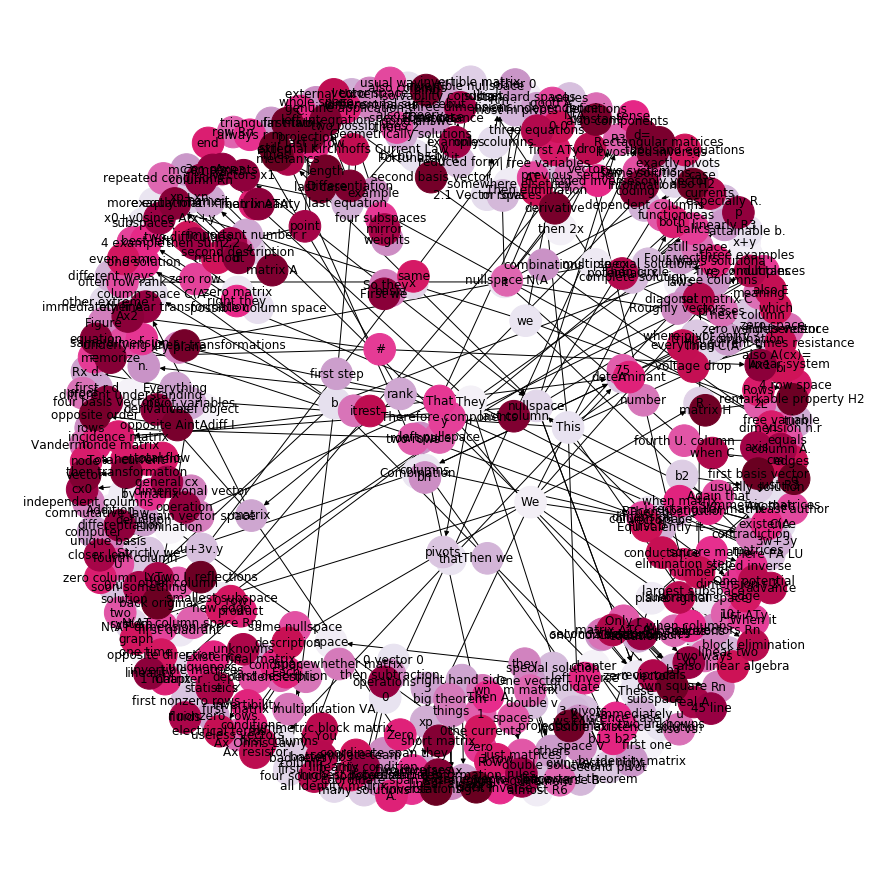

In [12]:
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, node_color=range(G.number_of_nodes()), 
        pos=pos, cmap=plt.cm.PuRd)
plt.show()


## Example of knowledge graph consisting only of nodes connected by relation `is`

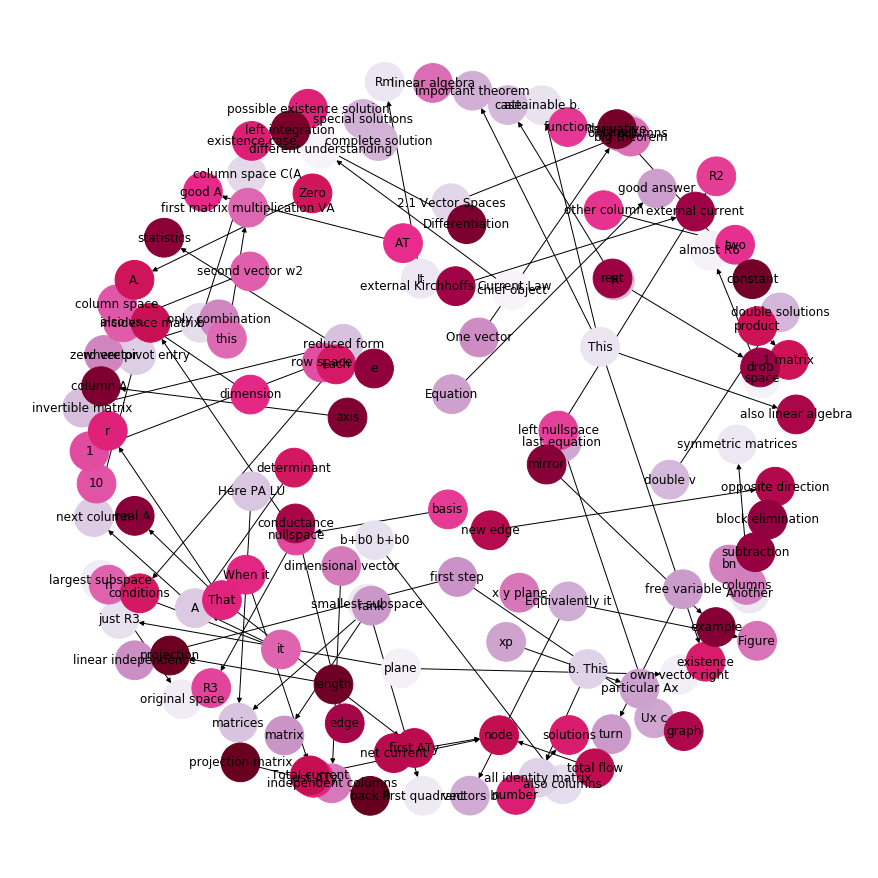

In [13]:
G_smol = nx.from_pandas_edgelist(kg_df[kg_df['link']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_smol, k=.4)
nx.draw(G_smol, with_labels=True, node_color=range(G_smol.number_of_nodes()), 
        node_size=1500, cmap=plt.cm.PuRd, pos=pos)
plt.show()


## Calculating sentences popularity
<br>
<font size="3.5">Popularity is weight of a sentence in a chapter.
Weight is the the sum of outdegrees of the vertices connected by the edge.
Basically, the goal is to find edges evolving around well connected vertices. On the assumption that well connected vertices in the graph are particularly relevant to the topic, this allows us to find the most interesting questions
for a user to answer.</font>

In [14]:
# Adding weights to graph edges for better question selection
popukarity = dict(G.out_degree())
popukarity['columns']

5

In [15]:
for u,v,d in G.edges(data=True):
    d['weight'] = popukarity[u] + popukarity[v]  # adding outdegres of two nodes connected by edge


In [16]:
# getting sorted indexes of best sentences

indexes = np.flip(np.argsort(np.array([x[2]['weight'] for x in G.edges(data=True)])))

# Getting distractors

In [17]:
import spacy
from distractors_generation import get_distractors
nlp_model = spacy.load(".")

# Quiz Construction

In [18]:
sentences = np.array(sentences)
top_sentences = sentences[indexes]
top_sentences[:10]

array(['It is denoted by N(A).',
       'Here is PA = LU for all matrices:\x0c 2.2',
       'We want to be able, for any system',
       'The\x0c 2.1 Vector Spaces and Subspaces 81 only combination of the columns is b = 0.',
       'At the other extreme, suppose A is the 5 by 5 identity matrix.',
       'b. This is not at all special to the identity matrix.',
       'Then C(A) can be somewhere between the zero space and',
       '= b is dual to the first.',
       'The nullspace contains only the vector (0;0).',
       'The vectors b are in the column space and the vectors'],
      dtype='<U128')

In [19]:
from quiz_generation import create_quiz

n = 10

quiz_sentences = top_sentences[:n]
subj_keys = subjects[indexes][:n]
obj_keys = objects[indexes][:n]
distractors = [get_distractors(chapter, str(obj_keys[i]).lower(), quiz_sentences[i].lower(), nlp_model, 3) for i in range(10)]
new_keys = [i[1][1] for i in distractors if i]
distractions = [i[0] for i in distractors if i]
print(create_quiz(list(zip(quiz_sentences, new_keys, distractions)), correct_answer=False,save=True))

other extreme key extrems ent


ValueError: substring not found